In [54]:
import networkx as nx 
from networkx import Graph, DiGraph
import pandas as pd
import time
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Question 1

In [4]:
asia_df = pd.read_csv('../data/lastfm_asia_edges.csv')
asia_df.head()

,node_1,node_2
0,0,747
1,1,4257
2,1,2194
3,1,580
4,1,6478


In [8]:
asia_df.values

array([[   0,  747],
       [   1, 4257],
       [   1, 2194],
       ...,
       [7533, 7536],
       [7569, 7587],
       [7580, 7595]], shape=(27806, 2))

In [11]:
asia_graph = Graph()
asia_graph.add_edges_from(asia_df.values)
print(asia_graph)

Graph with 7624 nodes and 27806 edges


In [15]:
centralities = dict(degree=lambda x:nx.degree_centrality(x),
                    eigenvector=lambda x: nx.eigenvector_centrality(x),
                    katz=lambda x:nx.katz_centrality(x),
                    pagerank=lambda x:nx.pagerank(x),
                    betweenness=lambda x:nx.betweenness_centrality(x),
                    closeness=lambda x:nx.closeness_centrality(x))

centrality_results = []

for key,val in centralities.items():
    start = time.time()
    print(f"Starting {key} centrality")
    if key=="katz":
        asia_digraph = DiGraph()
        asia_digraph.add_edges_from(asia_df.values)
        result = val(asia_digraph)
    else:
        result = val(asia_graph)
    print(f"Finished {key} centrality, time: {time.time() - start}")
    centrality_results.append(result.values())

starting degree centrality
Finished degree, centrality, time: 0.0069522857666015625
starting eigenvector centrality
Finished eigenvector, centrality, time: 0.8550238609313965
starting katz centrality
Finished katz, centrality, time: 0.6599338054656982
starting pagerank centrality
Finished pagerank, centrality, time: 0.06800556182861328
starting betweenness centrality
Finished betweenness, centrality, time: 379.03573870658875
starting closeness centrality
Finished closeness, centrality, time: 77.46279740333557


In [43]:
cols = list(centralities.keys())
stats_df = []
for cent1 in centrality_results:
    results = []
    for cent2 in centrality_results:
        results.append(pearsonr(list(cent1), list(cent2)))
    row = {col:res[0] for col,res in zip(cols, results)}
    stats_df.append(row)
stats_df = pd.DataFrame(stats_df, index=cols)
stats_df.head(10)

,degree,eigenvector,katz,pagerank,betweenness,closeness
degree,1.000000,0.473267,0.608252,0.954481,0.651081,0.561755
eigenvector,0.473267,1.000000,0.480827,0.354206,0.222756,0.288438
katz,0.608252,0.480827,1.000000,0.537027,0.440591,0.392195
pagerank,0.954481,0.354206,0.537027,1.000000,0.720708,0.502923
betweenness,0.651081,0.222756,0.440591,0.720708,1.000000,0.331302
closeness,0.561755,0.288438,0.392195,0.502923,0.331302,1.000000


It seems the centralities with the highest correlation are pagerank and degree centrality. While the least correlated centralities are betweenness and eigenvector centrality.

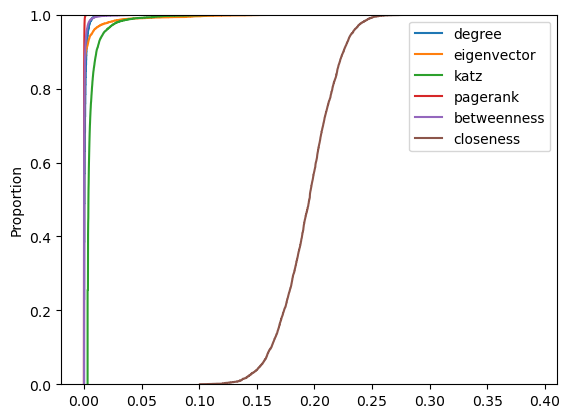

In [52]:
for col, cent in zip(cols, centrality_results):
    sns.ecdfplot(list(cent), label=col)
plt.legend()
plt.show()

# Question 2

In [193]:
graph = DiGraph()
graph.add_edges_from([
    (2,1),
    (1,3),
    (3,1),
    (1,4),
    (4,1),
    (3,2),
    (5,4),
    (2,5),
    (5,6),
    (6,2)
                      ])

print(graph)

DiGraph with 6 nodes and 10 edges


In [219]:
def page_rank(graph:DiGraph, centralities:np.ndarray, alpha:float, beta:np.ndarray, eps:float):
    n = len(centralities)
    if beta is None:
        beta = [0 for _ in range(n)]
    new_centralities = np.array([0.0 for _ in range(n)])
    for node_i in graph.nodes():
        new_centrality_val = 0
        for node_j in graph.nodes():
            if (node_j, node_i) in graph.edges():
                node_j_cent = centralities[node_j-1]
                ratio = node_j_cent/graph.out_degree(node_j)
                new_centrality_val += ratio
        new_centralities[node_i-1] = (alpha*new_centrality_val) + beta[node_i-1]

    new_centralities /= sum(new_centralities)
    diff_sum = np.sum(np.abs(new_centralities - centralities))
    if diff_sum < eps:
        return new_centralities
            
    return page_rank(graph, new_centralities, alpha, beta, eps)

In [220]:
beta = np.array([0.3, 0.2, 0.1, 0.1, 0.1, 0.4])
alpha = 0.85
n = graph.number_of_nodes()
centralities = np.array([1/n for _ in range(n)])
result_centralities = page_rank(graph, centralities, alpha, beta, eps=0.00000001)
for i,cent in enumerate(result_centralities):
    print(f"node {i+1}:{cent}")

node 1:0.26133263603473883
node 2:0.20770514703131146
node 3:0.10295920558215353
node 4:0.12199947730453437
node 5:0.09184131110536874
node 6:0.21416222294189302


# Question 3

In [225]:
hept_df = pd.read_csv('../data/cit-HepTh.txt', sep='\t')
hept_df.head()

,FromNodeId,ToNodeId
0,1001,9304045
1,1001,9308122
2,1001,9309097
3,1001,9311042
4,1001,9401139


In [241]:
hept_graph = DiGraph()
hept_graph.add_edges_from(hept_df.values)
hubs, authority = nx.hits(hept_graph)
hubs = dict(sorted(hubs.items(), key=lambda x:x[1], reverse=True))
authority = dict(sorted(authority.items(), key=lambda x:x[1], reverse=True))

In [244]:
best_hubs = []
best_authority = []

num_best = 3
for i, (key,val) in enumerate(hubs.items()):
    if i >= num_best:
        break
    best_hubs.append(key)
for i, (key,val) in enumerate(authority.items()):
    if i >= num_best:
        break
    best_authority.append(key)

In [247]:
print("Best hubs", [int(x) for x in best_hubs])
print("Best authority", [int(x) for x in best_authority])

Best hubs [9905111, 110055, 7170]
Best authority [9711200, 9802150, 9802109]


In [254]:
import os
from pathlib import Path

def print_abstract(node_id):
    folder_path = '../data/citation_abstracts'
    for folder in os.listdir(folder_path):
        sub_folder = Path(folder_path, folder)
        if sub_folder.is_dir():
            for filename in os.listdir(sub_folder):
                if str(node_id) in filename:
                    filename = Path(sub_folder, filename)
                    with open(filename) as file:
                        print(file.read())
                    return

In [255]:
for hub in best_hubs:
    print_abstract(hub)

------------------------------------------------------------------------------
\\
Paper: hep-th/9905111
From: Juan Maldacena <jmaldac@fas.harvard.edu>
Date: Fri, 14 May 1999 21:58:15 GMT   (320kb)
Date (revised v2): Mon, 14 Jun 1999 21:40:08 GMT   (321kb)
Date (revised v3): Fri, 1 Oct 1999 17:43:02 GMT   (322kb)

Title: Large N Field Theories, String Theory and Gravity
Authors: O. Aharony, S.S. Gubser, J. Maldacena, H. Ooguri, and Y. Oz
Comments: 261 pages, 42 post-script figures. Please send any comment to
  jmaldac@fas.harvard.edu. v2: added references and small corrections. v3:
  minor changes and corrected discussion of SU(3)-invariant supergravity
  solution
Report-no: CERN-TH/99-122, HUTP-99/A027, LBNL-43113, RU-99-18, UCB-PTH-99/16
Journal-ref: Phys.Rept. 323 (2000) 183-386
\\
  We review the holographic correspondence between field theories and string/M
theory, focusing on the relation between compactifications of string/M theory
on Anti-de Sitter spaces and conformal field the

As can be noted in the hub abstracts above, these are review papers. This naturally follows the intuition that hubs tell us where the best authorities can be found. Review papers typically review other papers on a specific subject and help us understand their legitimacy.

In [256]:
for authority in best_authority:
    print_abstract(authority)

------------------------------------------------------------------------------
\\
Paper: hep-th/9711200
From: Juan Maldacena <malda@physics.rutgers.edu>
Date: Thu, 27 Nov 1997 23:53:13 GMT   (22kb)
Date (revised v2): Mon, 8 Dec 1997 18:59:11 GMT   (23kb)
Date (revised v3): Thu, 22 Jan 1998 15:42:41 GMT   (23kb)

Title: The Large N Limit of Superconformal Field Theories and Supergravity
Authors: Juan M. Maldacena
Comments: 20 pages, harvmac, v2: section on AdS_2 corrected, references added,
  v3: More references and a sign in eqns 2.8 and 2.9 corrected
Report-no: HUTP-98/A097
Journal-ref: Adv.Theor.Math.Phys. 2 (1998) 231-252; Int.J.Theor.Phys. 38 (1999)
  1113-1133
\\
  We show that the large $N$ limit of certain conformal field theories in
various dimensions include in their Hilbert space a sector describing
supergravity on the product of Anti-deSitter spacetimes, spheres and other
compact manifolds. This is shown by taking some branes in the full M/string
theory and then taking a low

Looking on google scholar, the first paper has 25,741 citations, the second has 15,842 citation, and the third has 12,798 citations. This again follows the intuition that authorities give us important information, hence why these are highly cited papers.